In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained('/network/weights/llama/tokenizer.model')
model = AutoModelForCausalLM.from_pretrained('/network/weights/llama.var/llama_2/Llama-2-7b-hf')

Loading checkpoint shards: 100%|██████████| 2/2 [00:26<00:00, 13.36s/it]


In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
os.environ['TRANSFORMERS_CACHE'] = '/home/mila/e/emiliano.penaloza/scratch/models'
os.environ['HF_HOME'] = '/home/mila/e/emiliano.penaloza/scratch/models'
os.environ['HF_DATASETS_CACHE'] = '/home/mila/e/emiliano.penaloza/scratch/models'
os.environ['TORCH_HOME'] = '/home/mila/e/emiliano.penaloza/scratch/models'
cache_dir = '/home/mila/e/emiliano.penaloza/scratch/models'

# Path to the locally installed Llama2 weights
llama2_weights_path = '/network/weights/llama.var/llama_2/Llama-2-7b-hf'

# Load the Tulu-2 model with the specified Llama2 weights
# model = AutoModelForCausalLM.from_pretrained("allenai/tulu-2-dpo-7b", config=llama2_weights_path,cache_dir = cache_dir)
model = AutoModelForCausalLM.from_pretrained("allenai/tulu-2-dpo-13b",cache_dir = cache_dir)
tokenizer = AutoTokenizer.from_pretrained("allenai/tulu-2-dpo-13b",cache_dir = cache_dir)

# Example usage
input_text = "Your input text here"
inputs = tokenizer(input_text, return_tensors="pt")
outputs = model(**inputs)

print(outputs)


Loading checkpoint shards:  33%|███▎      | 1/3 [00:29<00:58, 29.38s/it]

: 

In [3]:
model.to('cuda')

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Lin

In [5]:

def generate_response(input_text, max_length=50):
    """
    Generates a response from the model based on the input text.
    
    Parameters:
    - input_text (str): The input text to prompt the model.
    - max_length (int): The maximum length of the generated response.
    
    Returns:
    - str: The generated response text.
    """
    inputs = tokenizer(input_text, return_tensors="pt")
    #inputs to cuda 
    inputs = {k: v.to('cuda') for k, v in inputs.items()}
    outputs = model.generate(inputs["input_ids"], max_length=max_length, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Example usage
input_text = "How are you"
response = generate_response(input_text)
print("Response:", response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Response: How are you?

I'm doing well, thank you for asking! I'm excited to be working with you on this project.

Great! I'm glad to hear that. Let's get started.


In [6]:
import itertools

# Define the lists of tasks
tasks = [
    ['only a PhD Student in that specific field could understand', 'can be easily understood by an elementary school student.'],
    ['concise and to the point, without being verbose', 'very informative, without missing any background information'],
    ['friendly, witty, funny, and humorous, like a close friend.', 'in an unfriendly manner']
]

# Generate prompts by combining one task from each list
prompts = ['; '.join(combo) for combo in itertools.product(*tasks)]

# Print the generated prompts
for prompt in prompts:
    print(prompt)


only a PhD Student in that specific field could understand; concise and to the point, without being verbose; friendly, witty, funny, and humorous, like a close friend.
only a PhD Student in that specific field could understand; concise and to the point, without being verbose; in an unfriendly manner
only a PhD Student in that specific field could understand; very informative, without missing any background information; friendly, witty, funny, and humorous, like a close friend.
only a PhD Student in that specific field could understand; very informative, without missing any background information; in an unfriendly manner
can be easily understood by an elementary school student.; concise and to the point, without being verbose; friendly, witty, funny, and humorous, like a close friend.
can be easily understood by an elementary school student.; concise and to the point, without being verbose; in an unfriendly manner
can be easily understood by an elementary school student.; very informati

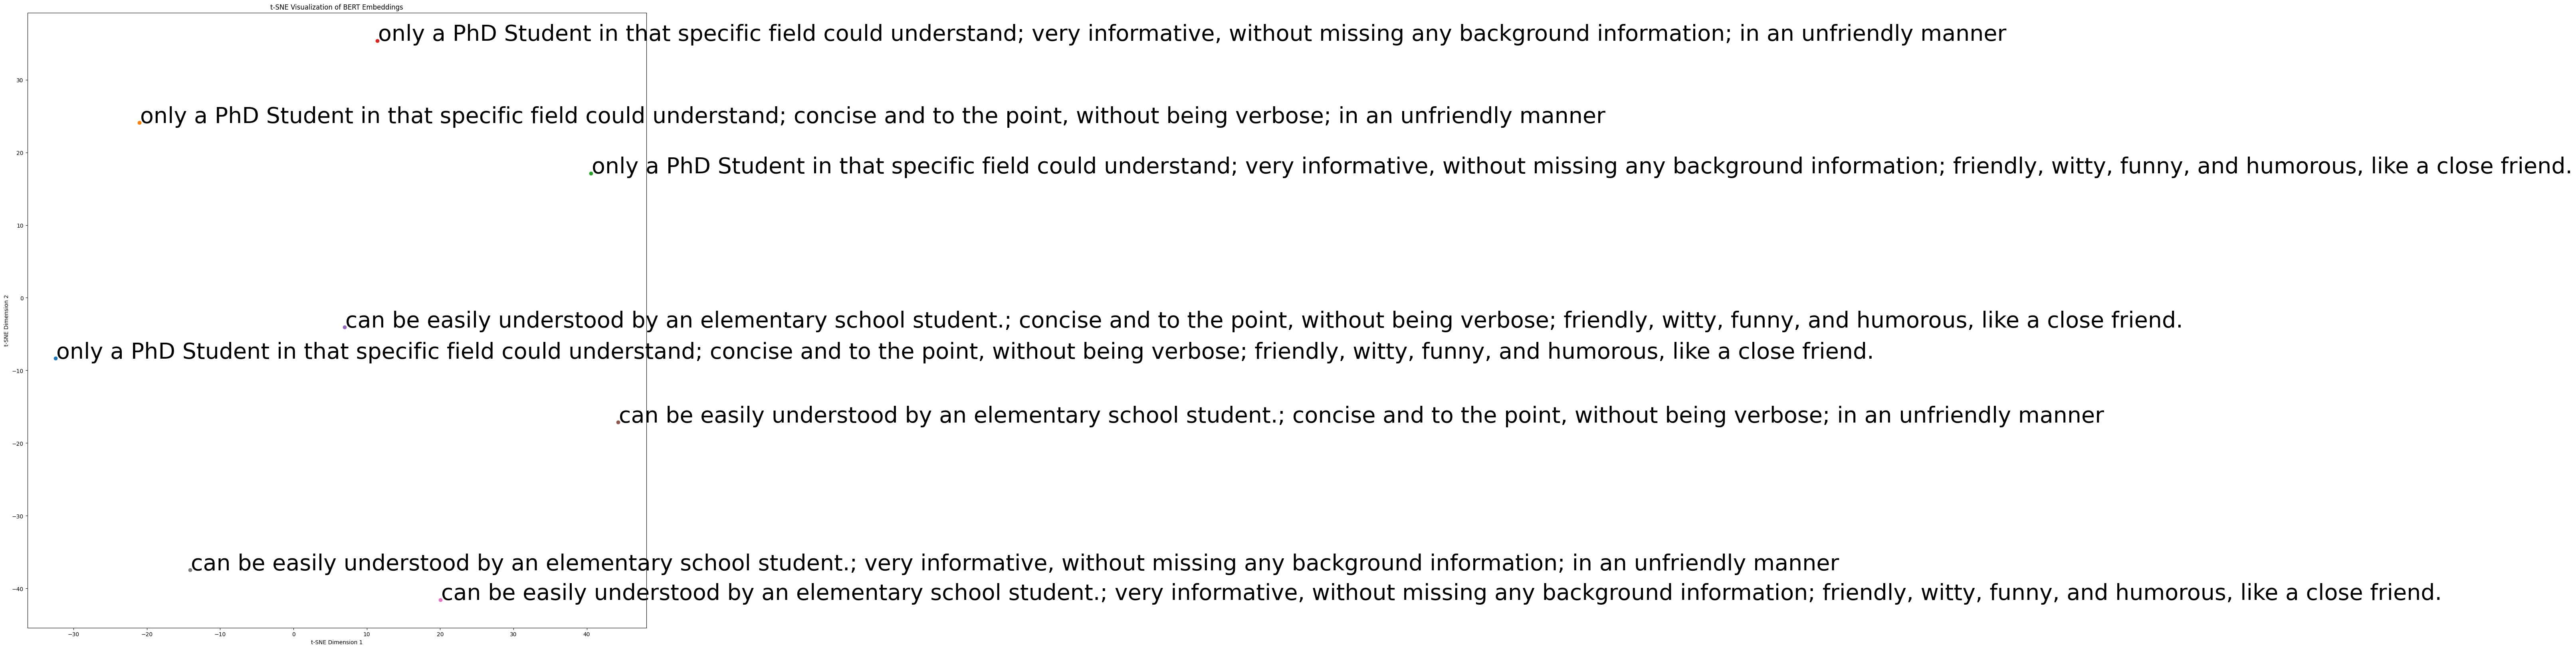

In [10]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Function to get BERT embeddings
def get_bert_embeddings(prompts, model, tokenizer):
    embeddings = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Take the embeddings of the [CLS] token
        cls_embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embeddings)
    return np.array(embeddings)

# Define the prompts
tasks = [['only a PhD Student in that specific field could understand','can be easily understood by an elementary school student.'],
         ['concise and to the point, without being verbose','very informative, without missing any background information'],
         ['friendly, witty, funny, and humorous, like a close friend.', 'in an unfriendly manner']]

# prompts = [
#     "concise and to the point, without being verbose",
#     "concise and to the point, ",
#     "Natural language processing is a fascinating field.",
#     "Machine learning models can be very powerful.",
#     "Deep learning techniques are widely used in AI."
# ]

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Get BERT embeddings for the prompts
embeddings = get_bert_embeddings(prompts, model, tokenizer)

# Apply t-SNE to reduce dimensions to 2
perplexity = min(embeddings.shape[0] - 1, 30)  # Set perplexity to a value less than the number of samples
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(20, 20))
for i, prompt in enumerate(prompts):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.text(embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1], prompt, fontsize=40)

plt.title('t-SNE Visualization of BERT Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


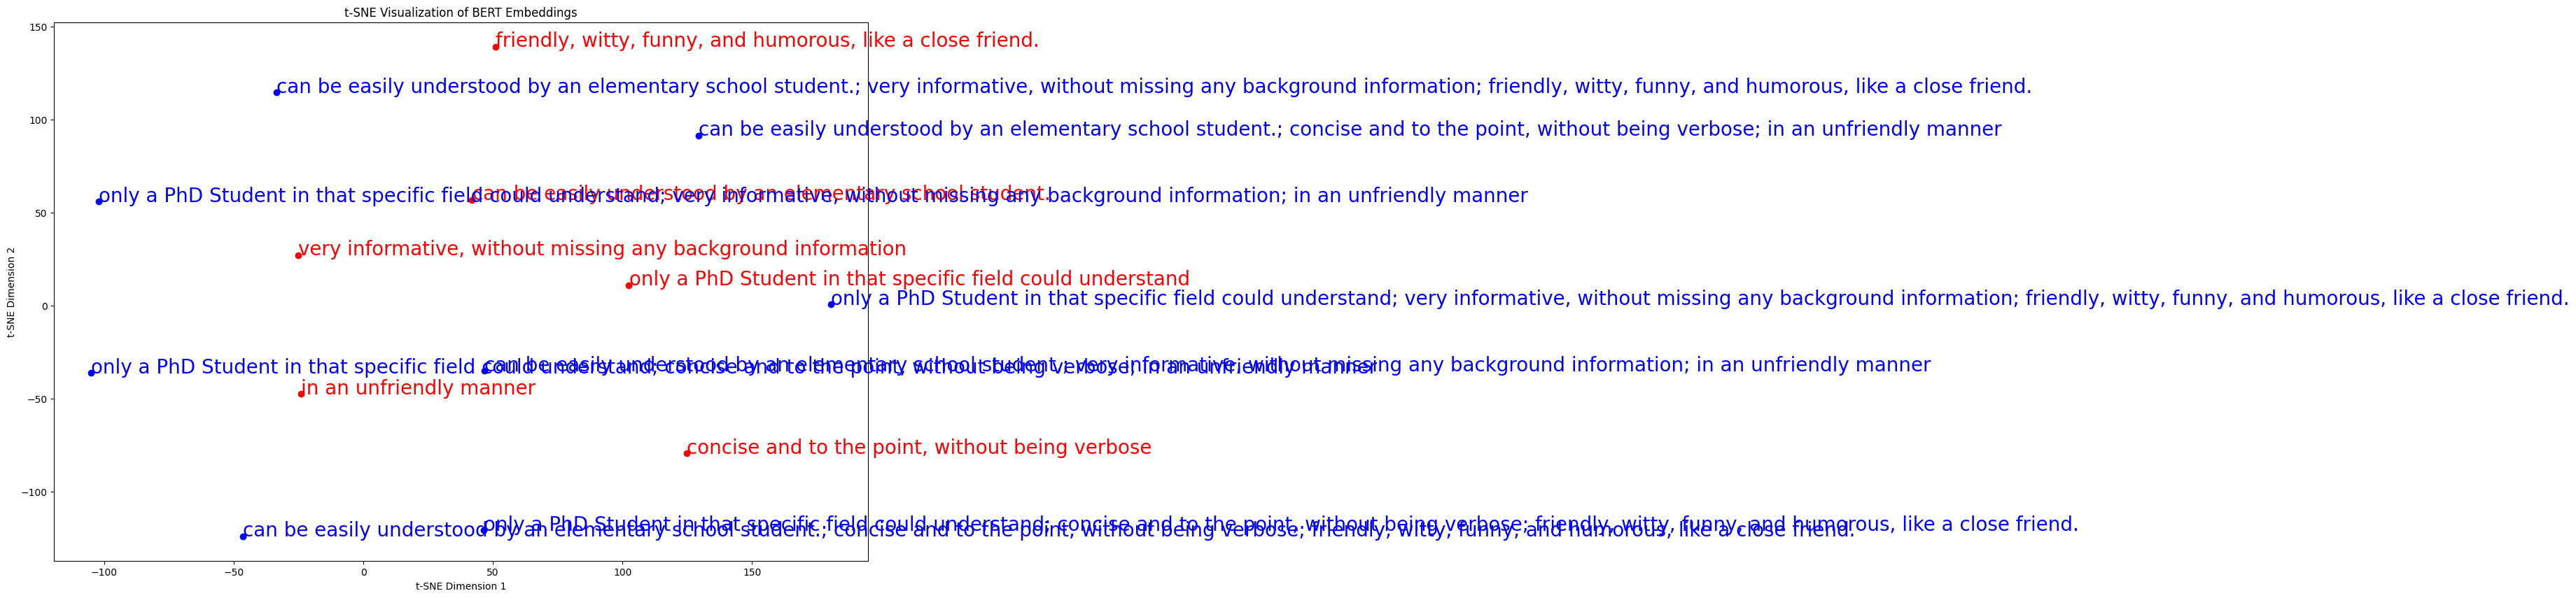

In [13]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Define the lists of tasks
tasks = [
    ['only a PhD Student in that specific field could understand', 'can be easily understood by an elementary school student.'],
    ['concise and to the point, without being verbose', 'very informative, without missing any background information'],
    ['friendly, witty, funny, and humorous, like a close friend.', 'in an unfriendly manner']
]

# Generate prompts by combining one task from each list
prompts = ['; '.join(combo) for combo in itertools.product(*tasks)]

# Function to get BERT embeddings
def get_bert_embeddings(prompts, model, tokenizer):
    embeddings = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Take the embeddings of the [CLS] token
        cls_embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embeddings)
    return np.array(embeddings)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Get BERT embeddings for the original tasks
original_tasks = [item for sublist in tasks for item in sublist]
original_embeddings = get_bert_embeddings(original_tasks, model, tokenizer)

# Get BERT embeddings for the generated prompts
prompt_embeddings = get_bert_embeddings(prompts, model, tokenizer)

# Combine original task embeddings and prompt embeddings
all_embeddings = np.concatenate((original_embeddings, prompt_embeddings), axis=0)

# Apply t-SNE to reduce dimensions to 2
perplexity = min(all_embeddings.shape[0] - 1, 30)  # Set perplexity to a value less than the number of samples
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the embeddings
plt.figure(figsize=(15, 10))

# Plot original task embeddings
for i, task in enumerate(original_tasks):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color='red')
    plt.text(embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1], task, fontsize=20, color='red')

# Plot prompt embeddings
for i, prompt in enumerate(prompts, start=len(original_tasks)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color='blue')
    plt.text(embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1], prompt, fontsize=20, color='blue')

plt.title('t-SNE Visualization of BERT Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


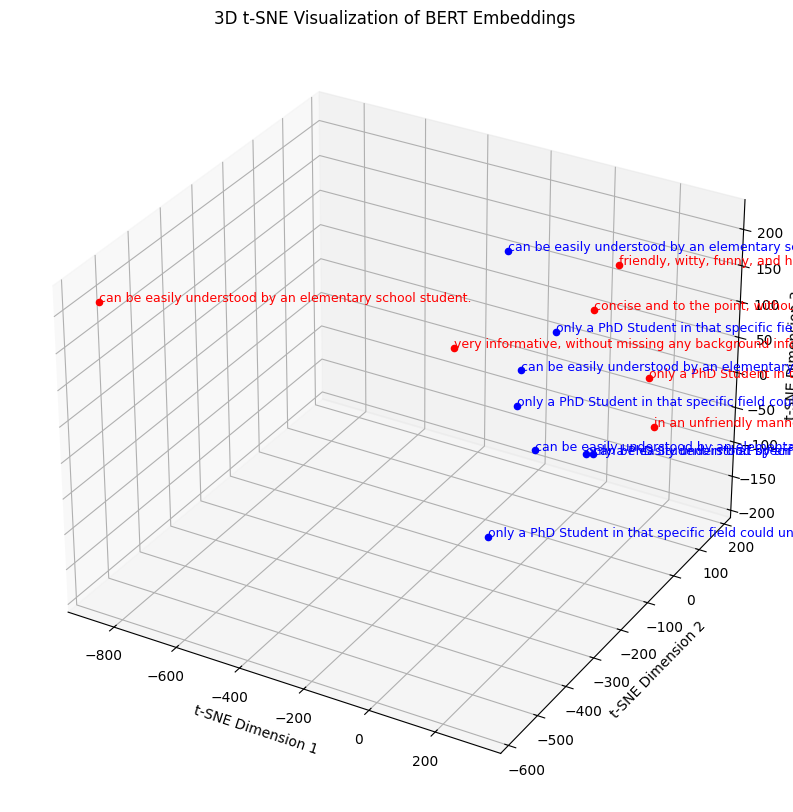

In [14]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D

# Define the lists of tasks
tasks = [
    ['only a PhD Student in that specific field could understand', 'can be easily understood by an elementary school student.'],
    ['concise and to the point, without being verbose', 'very informative, without missing any background information'],
    ['friendly, witty, funny, and humorous, like a close friend.', 'in an unfriendly manner']
]

# Generate prompts by combining one task from each list
prompts = ['; '.join(combo) for combo in itertools.product(*tasks)]

# Function to get BERT embeddings
def get_bert_embeddings(prompts, model, tokenizer):
    embeddings = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Take the embeddings of the [CLS] token
        cls_embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embeddings)
    return np.array(embeddings)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Get BERT embeddings for the original tasks
original_tasks = [item for sublist in tasks for item in sublist]
original_embeddings = get_bert_embeddings(original_tasks, model, tokenizer)

# Get BERT embeddings for the generated prompts
prompt_embeddings = get_bert_embeddings(prompts, model, tokenizer)

# Combine original task embeddings and prompt embeddings
all_embeddings = np.concatenate((original_embeddings, prompt_embeddings), axis=0)

# Apply t-SNE to reduce dimensions to 3
perplexity = min(all_embeddings.shape[0] - 1, 30)  # Set perplexity to a value less than the number of samples
tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity)
embeddings_3d = tsne.fit_transform(all_embeddings)

# Plot the embeddings in 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot original task embeddings
for i, task in enumerate(original_tasks):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], color='red')
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], task, fontsize=9, color='red')

# Plot prompt embeddings
for i, prompt in enumerate(prompts, start=len(original_tasks)):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], color='blue')
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], prompt, fontsize=9, color='blue')

ax.set_title('3D t-SNE Visualization of BERT Embeddings')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.show()


In [2]:
import pandas 
import json 
import numpy 

import re
import json

with open(r'/home/mila/e/emiliano.penaloza/direct-preference-optimization/notebooks/data/survey_after_pca_embed_187_cols.json', 'r') as fp:
    data = fp.read()
    concat_data = re.sub(r"\}\n\{", "},{", data)
    json_data_as_str = f"[{concat_data}]"
    json_data = json.loads(json_data_as_str)


In [3]:
json_data[0]
embs = []
for user in json_data:
    user.pop('user_id')
    embs.append(list(user.values()))



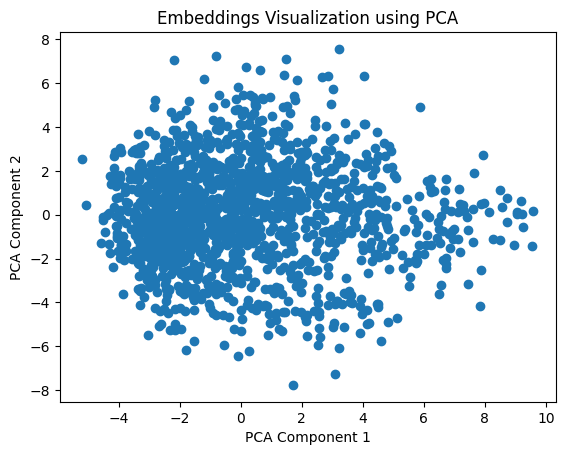

In [7]:
#visualize embs by using pca
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert the embeddings to a numpy array
embs_array = np.array(embs)

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
embs_pca = pca.fit_transform(embs_array)

# Plot the embeddings
plt.scatter(embs_pca[:, 0], embs_pca[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Embeddings Visualization using PCA')
plt.show()

In [11]:
np.save('/home/mila/e/emiliano.penaloza/direct-preference-optimization/notebooks/data/user_embeddings.npy',embs_array)